### Regression in a nutshell
With the classification problems, for each input, the model predicts a *discrete* label. However, with classification problems the predicted label is *continuous*. For example, predicting temperature tomorrow given meterological data or predicting the median price of a house given the crime statistics of the neighbourhood.

### Imports and the Boston Housing dataset

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

This is a dataset taken from the StatLib library which is maintained at Carnegie Mellon University. 
Samples contain 13 attributes (e.g. crime rates, local property tax rates, access to the highway, number of rooms per dwelling) of houses at different locations around the Boston suburbs in the late 1970s. The targets are the median values of the houses at a location (in k$).

In [2]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


There are 404 training samples and 102 test samples. The targets are the median values of the houses at a location (in k$).

In [3]:
print(min(train_targets))
print(max(train_targets))
print(np.mean(train_targets))

5.0
50.0
22.395049504950492


### Preparing the data
It would be inefficient to feed the neural network attribute values with wildly different ranges. So, to deal with such data we do *feature-wise normalization*: for each feature in the input
data (a column in the input data matrix), you subtract the mean of the feature and
divide by the standard deviation, so that the feature is centered around 0 and has a
unit standard deviation. This can be done with Numpy.

In [4]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

Note that the mean and std of the train_data are used to normalize the test_data too - it is best practice to not use any quanity in your workflow that is computed from the test_data. 

### Building the network
In general, the less training data you have, the worse overfitting will be. So, we will work with a realtively small network, as this is an obvious way to combat overfitting. 

In [5]:
from keras import models
from keras import layers
def build_model(): # We use a function here, as we will need to instantiate the model multiple times.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
    input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1)) 
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

We end with a single unit and no actication function (linear layer) which is typical of scalar regression (predicting a single continuous value). An activation function would contrain the range of the output, which we do not want. The 'mse' or *mean square error* is the square of the difference between the prediction and the targets and is widely used in regression problems. The metric being monitored is the *mean absolute error* which is simply the absolute value of the difference between the predictions and the targets.

### Validating the approach using K-fold cross-validation 
We use this method here because there are few training samples which means that the validation
scores could have a high variance with regard to the validation split. *K-fold cross-validation* consists of splitting the available data into K partitions (typically K = 4 or 5), instantiating K identical models, and training each one on K – 1 partitions while evaluating on
the remaining partition. The validation score for the model used is then the average of
the K validation scores obtained

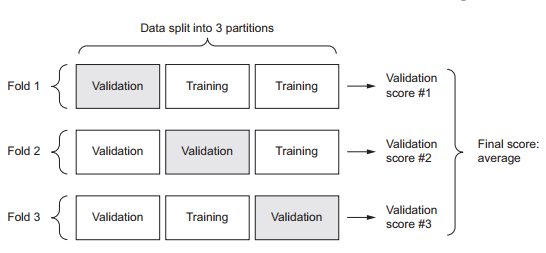

In [6]:
# k = 4
# num_val_samples = len(train_data) // k #floor division 
# num_epochs = 100
# all_scores = []

# for i in range(k):
#     print('processing fold #', i)
#     val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] # Prepares the validation data from partition K
#     val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
#     partial_train_data = np.concatenate( 
#         [train_data[:i * num_val_samples], 
#          train_data[(i + 1) * num_val_samples:]], 
#         axis=0) # prepares training data: data from all other partitions
#     partial_train_targets = np.concatenate(
#         [train_targets[:i * num_val_samples], 
#          train_targets[(i + 1) * num_val_samples:]],
#         axis=0)
#     model = build_model()
#     model.fit(partial_train_data, partial_train_targets,
#               epochs=num_epochs, batch_size=1, verbose=0) # Trains the model in silent mode (verbos = 0)
#     val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
#     all_scores.append(val_mae) # mean absolute error

# print(all_scores)
# print(np.mean(all_scores))

In [7]:
print(np.mean(all_scores)) 

NameError: name 'all_scores' is not defined

This average valdiation score a much more reliable any single validation score. Now, let's increase the number of epochs and save the validation score log for every epoch. 

In [ ]:
k = 4
num_val_samples = len(train_data) // k #floor division 
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate( [train_data[:i * num_val_samples], 
                                          train_data[(i + 1) * num_val_samples:]],
                                        axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]],
                                           axis=0)
    model = build_model() # Builds the (already compiled) model
    history = model.fit(partial_train_data, partial_train_targets, 
                        validation_data = (val_data, val_targets), 
                        epochs = num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

Note, with the history method, we are keeping a record of the per-epoch MAE scores for all folds, as opposed to just the final MAE score (after 100 epochs) for all each fold. This is useful because it allows us to compute the average of the per-epoch MAE scores for all folds; 

In [ ]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

and to see at what epoch overfitting begins feature. For this, it is important to understand the roles that the batch size and the number of epochs play:

"You can think of a for-loop over the number of epochs where each loop proceeds over the entire training dataset. Within this for-loop is another nested for-loop that iterates over each batch of samples, where one batch has the specified batch size number of samples." 

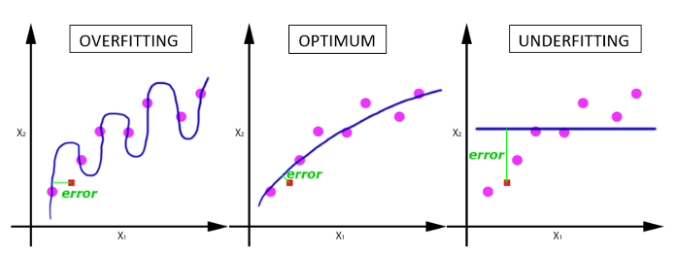

https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9
https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/.

Because traning data is often limited, it can be useful to train a model on the same data more than once. This allows the model to evolve from being underfitted to having an optimal fittedness. However, as the number of epochs increases, the model can become overfitted. Hence, one needs to optimize the number of epochs.

**Plotting the validation scores against the number of epochs**:

In [ ]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

The problem with this graph is that the first 10 or so data points lie on a different scale to the others making it difficult to see what is happening. To make the trend even clearer we can replace each point with an exponential moving average of the previous points to obtain a smooth curve.

In [ ]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor)) # See definition of the exponential moving average
        else:
            smoothed_points.append(point)
    return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to this plot, validation MAE stops improving significantly after 80 epochs. This process has allowed us to fine tune the number-of-epochs hyperparameter. (Similarly, their are methods to fine tune batch size and the number of hidden layers.) Once these these hyperparameters have been fine tuned, the final production model can be trained on all the training data...

In [9]:
model = build_model() # new model
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets) 


102/102 [==============================] - 0s 205us/step


### Summary 
* The mean square error is often used as the loss function in regression problems
* The MAE is a common metric of evaluation for regression problems
* When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
* When there is little data available, using K-fold validation is a great way to reliably evaluate a model
* When little training data is available it is wise to use few hidden layers (typically one or two) to avoid overfitting. 